# Self-Organising Maps

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines


# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [2]:
data.shape

(105, 6)

In [3]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [4]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
58,4226,3973,940
42,8550,6430,752
84,27200,33124,1218
88,13554,17624,1300
44,8820,4890,554
39,140171,1531315,10925
52,6028,5447,904
92,9000,10000,1111
61,3398,3310,974
14,190429,119731,629


In [5]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
58,0.022192,0.001672,0.023373
42,0.044899,0.002706,0.018699
84,0.142835,0.013940,0.030286
88,0.071176,0.007417,0.032325
44,0.046316,0.002058,0.013775
39,0.736080,0.644465,0.271651
52,0.031655,0.002292,0.022478
92,0.047262,0.004209,0.027625
61,0.017844,0.001393,0.024219
14,1.000000,0.050390,0.015640


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

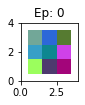

In [6]:
from our_som1A import SOM

# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [7]:
def predict(df, agri_som):
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df


In [8]:
def arrange_data(agri_som):
    clustered_df = trunc_data.apply(predict, axis=1, agri_som=agri_som)
    joined_df = agri_data.join(clustered_df, rsuffix="_norm")
    return joined_df

In [9]:
def external_purity(df):
    """Purity measures the purity of clusters with respect to ground-truth class labels. To compute the purity of a clustering Q, 
    each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured 
    by counting the number of correctly assigned points and dividing by the total number of points:

    Prospers Comment:
        with this implementation, the computation of the total_correct includes classes located in multiple clusters. 
        For instance, if POTATO is located in [0,0] with count of 20, and also located in [2,2] with count of 40, both instances are 
        included in the computation of the total_correct. But with the definition, POTATO will be assigned to the cluster [2,2] and 
        not [0,0] also, so computation will include only 40 for 'POTATO'. Kindly verify that.
        For this reason, I implemented a proposed edition tagged 'prospers_purity' correcting this error.

    Args:
        df (pd.DataFrame): joined training set with bmu positions and weights
    """
    classes = [str(i) for i in df.bmu_idx.tolist()]  # all neurons/clusters responsible each data point
    classes_uniq = set(classes)  # unique neurons (<= 9 since 3*3 grid. less if some neuron(s) dont have any samples)
    clusters = {i:{} for i in classes_uniq}  # build associative array to hold all samples for each neuron.

    data = [[str(i),j] for i,j in zip(df.bmu_idx.tolist(), df.Crop)]
    for i in classes_uniq:
        for j in data:
            exact= j[0]
            pred = j[1]
            if exact == i:
                if pred not in clusters[exact].keys():
                    clusters[exact][pred] = 1
                else:
                    clusters[exact][pred] += 1
    total_correct = 0
    total = len(data)
    for cluster in clusters.values():
        total_correct += max(cluster.values())
    
    return total_correct/total


def prospers_purity(df):
    """Implemented to correct the over summand error in the above implementation
    """
    # proper representation of column
    df['bmu_idx'] = df['bmu_idx'].apply(lambda k: str(k))
    df['bmu'] = df['bmu'].apply(lambda k: k[0])

    # fetch number of different samples associated to each cluster.
    clusters = df.value_counts(subset=['Crop', 'bmu_idx']).reset_index() 
    clusters.rename(columns={0:'count'}, inplace=True)

    total = np.sum(clusters['count'])  # compute total number of points

    # assign class which is most frequent in the cluster. highest count of that specific crop type in cluster
    cluster_dominated = clusters.groupby(by=['Crop']).max().reset_index()
    total_correct = np.sum(cluster_dominated['count'])  # compute total number of correctly clustered
    
    return total_correct/total

    

def cluster_accuracy(df):
    """
    The cluster accuracy as specified in the reference is the number of samples assigned to the correct class divided by the total 
    number of samples. It can also be used in clustering as an external quality measure if labels are available and if 
    the number of clusters is equal to the number of classes (which is not our case, yet, I tried implementing). ...

    Comments:
        The cluster matrix was sparse leading to obtaining non-optimal result using the hungarian method which sought to 
        minimize the sum function. You can verify that with the below implementation.
    """
    from scipy.optimize import linear_sum_assignment  # for hungarian optimization

    # representing df in a proper format
    df['bmu_idx'] = df['bmu_idx'].apply(lambda k: str(k))
    df['bmu'] = df['bmu_idx'].apply(lambda k: k[0])

    # fetch classes and unique classes
    unique_classes = df['bmu_idx'].apply(lambda k: str(k)).unique()
    classes = df['bmu'].apply(lambda k: str(k[0])).unique()

    # compute the cluster matrix to minimize sum
    cost = df.pivot_table(index='Crop', columns='bmu_idx', values='Area', aggfunc='count', fill_value=0)

    row_ind, col_ind = linear_sum_assignment(cost)  # optimal locations

    cost.values[row_ind, col_ind].sum()  # optimal locations result to 0 sum.

In [10]:
def visualize(joined_df, lr, lf,agri_som):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111)
    scale = 50
    ax.set_xlim((0, agri_som.net.shape[0]*scale))
    ax.set_ylim((0, agri_som.net.shape[1]*scale))
    ax.set_title("learning function: "+lf+", learning rate: "+str(lr))

    for x in range(0, agri_som.net.shape[0]):
        for y in range(0, agri_som.net.shape[1]):
            ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                         facecolor='white',
                         edgecolor='grey'))
    legend_map = {}

    for index, row in joined_df.iterrows():
        x_cor = row['bmu_idx'][0] * scale
        y_cor = row['bmu_idx'][1] * scale
        x_cor = np.random.randint(x_cor, x_cor + scale)
        y_cor = np.random.randint(y_cor, y_cor + scale)
        color = row['bmu'][0]
        marker = "$\\ " + row['Crop'][0]+"$"
        marker = marker.lower()
        ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
        label = row['Crop']
        if not label in legend_map:
            legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                              markersize=10, label=label)
    plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
    plt.show()

In [11]:
external_purities = []
prospers_purities = []

def run(lr, lf):
    """wrapper function. implements the SOM with the given parameters

    Args:
        lr (float): learning rate to perform the SOM algorithm with.
        lf (string): one of the 4 implemented functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=100,
          init_learning_rate=lr,
          learning_rate_funtion=lf
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities.append(external_purity(joined_df))
    prospers_purities.append(prospers_purity(joined_df))

In [24]:
lrs = [1, 0.1, 0.01, 0.001]
lfs = ["default", "linear", "inverse", "power"]

# build a dense combination of lrs and lfs
mesh = np.array(np.meshgrid(lrs, lfs))
lrs_lfs = mesh.T.reshape(-1, 2)

for lr, lf in lrs_lfs:
    lr = lr.astype('float64')
    run(lr=lr, lf=lf)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [25]:
!pip install tabulate
from tabulate import tabulate

In [35]:
table = []  # initialize table

# building table
for pos in range(len(lrs_lfs)):
	table.append([lrs_lfs[pos][0], lrs_lfs[pos][1], external_purities[pos], prospers_purities[pos]])

headers = ["lr", "lf", 'external_purity', 'prospers_accuracy']
print(tabulate(table, headers, tablefmt="pretty"))

+-------+---------+--------------------+--------------------+
|  lr   |   lf    |  external_purity   | prospers_accuracy  |
+-------+---------+--------------------+--------------------+
|  1.0  | default |        0.8         | 0.8666666666666667 |
|  1.0  | linear  |        0.8         | 0.8571428571428571 |
|  1.0  | inverse | 0.7904761904761904 | 0.780952380952381  |
|  1.0  |  power  |        0.8         | 0.8571428571428571 |
|  0.1  | default |        0.8         | 0.8571428571428571 |
|  0.1  | linear  |        0.8         | 0.8571428571428571 |
|  0.1  | inverse |        0.8         | 0.8571428571428571 |
|  0.1  |  power  | 0.8095238095238095 | 0.9047619047619048 |
| 0.01  | default | 0.8095238095238095 | 0.8666666666666667 |
| 0.01  | linear  | 0.6952380952380952 | 0.8666666666666667 |
| 0.01  | inverse |        0.8         | 0.7714285714285715 |
| 0.01  |  power  | 0.6761904761904762 | 0.8095238095238095 |
| 0.001 | default |        0.8         | 0.8380952380952381 |
| 0.001 